In [1]:
from rinarak.domain import load_domain_string, Domain
domain_parser = Domain("mvcl/base.grammar")

meta_domain_str = ""
with open(f"domains/demo_domain.txt","r") as domain:
    for line in domain: meta_domain_str += line
domain = load_domain_string(meta_domain_str, domain_parser)

#domain.print_summary()

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


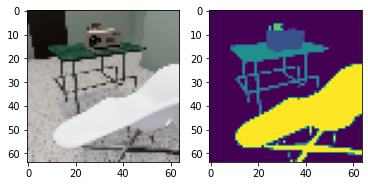

In [2]:
import matplotlib.pyplot as plt
from mvcl.primitives import *
from rinarak.knowledge.executor import CentralExecutor
from mvcl.model import MetaVisualLearner
from mvcl.config import config
from datasets.tdw_dataset import TDWRoomDataset
local = not torch.cuda.is_available()
syq_path = "/Users/melkor/Documents/datasets"
wys_path = "/data3/guofang/Meta/Benchmark/MultiPaperQA/wys_try/datasets"
dataset_dir = syq_path if local else wys_path

resolution = (64,64)
W, H = resolution
config.resolution = resolution
B, N, K = 1, W * H, 5
M = 1

dataset = TDWRoomDataset(resolution = resolution, root_dir = dataset_dir, split = "test")
loader = torch.utils.data.DataLoader(dataset, batch_size = B, shuffle = True)
for sample in loader:break;
"""load the dataset and make the ideal images and masks"""

ims = sample["img"]
target_masks = sample["masks"]
plt.subplot(121)
plt.imshow(ims[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(target_masks[0])
plt.show()

In [5]:
from tqdm import tqdm
from mvcl.primitives import *
model = MetaVisualLearner(domain, config)
model.add_affinities(["albedo"])
model.grouper.competition.M = M

programs = [["(exists (green  (object $0) ))"],
            ["(exists (square $0))"],
            ["(exists (red (object $0)))"],
            ["(red (object $0))"],
            ["(green (object $0))"]]
#programs = [[" (green $0)"], [" (square $0)"], ["(exists (green $0))"]]
answers = [["yes"],["yes"], ["yes"], ["namo"], ["namo"]]


executor = model.central_executor
"""
x["executor"].entailment(x["features"],
            x["executor"].get_concept_embedding(name))
"""
for predicate in executor.predicates[1]:refractor(executor, predicate.name)
executor.redefine_predicate("object",
                            lambda x: {**x}
                            )


percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"]
indices = percept_outputs["indices"]
predict_masks, _ ,alive, prop_maps = model.extract_segments(obj_affinity, indices)
predict_masks = torch.einsum("bwhn,bnd->bwhn", predict_masks, alive)

alive = torch.ones_like(alive)
rand_features = torch.randn([B, M, 100])
rand_features.requires_grad_ = True

query_outputs = model.language_grounding(
    percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
print(query_outputs)

optim = torch.optim.Adam(executor.parameters(), lr = 2e-3)
for epoch in tqdm(range(1000)):
    query_outputs = model.language_grounding(
        percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
    loss = query_outputs["loss"]
    optim.zero_grad()
    loss.backward()
    optim.step()

query_outputs = model.language_grounding(
    percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
print(query_outputs)

{'loss': tensor(0.9970, grad_fn=<DivBackward0>), 'answers': [['no', 'no', 'no', tensor([-1.8985], grad_fn=<MinimumBackward0>), tensor([-0.6480], grad_fn=<MinimumBackward0>)]]}


100%|██████████| 1000/1000 [00:02<00:00, 348.03it/s]

{'loss': tensor(0.2801, grad_fn=<DivBackward0>), 'answers': [['no', 'yes', 'no', tensor([-0.0109], grad_fn=<MinimumBackward0>), tensor([-0.0030], grad_fn=<MinimumBackward0>)]]}
